## Importação das bibliotecas e base de dados

In [1]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
xray_directory = 'data\Dataset'

In [3]:
os.listdir(xray_directory)

['0', '1', '2', '3']

In [4]:
# Instanciando objeto de ImageDataGenerator para acessar as imagens e aplicando rescale para normalizar os valores dos pixels

image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
# Buscando as imagens de treino no diretório

# batch_size = quantidade de imagens por batch,
# directory = diretório das imagens,
# shuffle = True para embaralhar as imagens,
# target_size = definição do tamanho das imagens,
# class_mode = 'categorical' para classificação multiclasse,
# subset = 'training' indicando que as imagens são de treino

train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [8]:
133 * 4

532

In [9]:
532 / 40

13.3

In [10]:
train_images, train_labels = next(train_generator)

In [13]:
# 40 - quantidade de imagens por batch
# 256 - altura das imagens
# 256 - largura das imagens
# 3 - quantidade de canais de cores (RGB)

train_images.shape

(40, 256, 256, 3)

In [14]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]],

In [15]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

## Visualização dos dados

In [16]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [17]:
np.argmax(train_labels[0])

0

In [18]:
labels_names[2]

'Pneunomia viral'

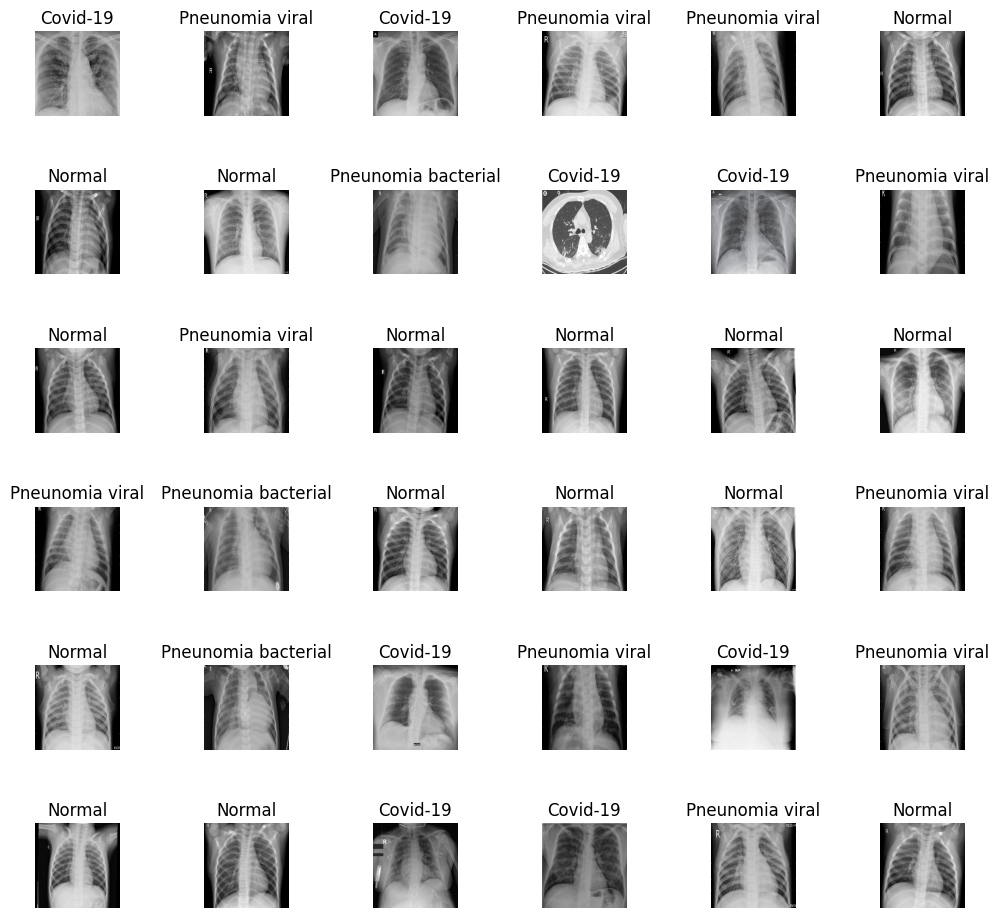

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.0)

## Carregamento da rede neural com pesos pré-treinados

In [20]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

In [21]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
len(base_model.layers)

175

In [25]:
# Congelando as últimas camadas do modelo. 
# Permite fazer um treinamento mais rápido, mas isso pode ter um impacto no desempenho do algoritmo.
# Avaliar a acurácia do modelo com as camadas congeladas e sem as camadas congeladas.

# for layer in base_model.layers[:-10]:
#     layer.trainable = False

## Construção e treinamento do modelo de deep learning

In [23]:
# A variavel head_model é a parte do modelo que será treinada e esta ligada ao modelo base.
# AveragePooling2D - Camada de pooling que calcula a média dos valores dos pixels.
# Flatten - Transforma a matriz de pixels em um vetor.
# Dense - Camada densa de 256 neurônios.
# Dropout - Regularização para evitar overfitting.
# Dense - Camada densa de 256 neurônios.
# Dropout - Regularização para evitar overfitting.
# Dense - Camada densa de 4 neurônios com função de ativação softmax.


head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [24]:
# Criando o modelo final

# inputs = camada de entrada do modelo
# outputs = camada de saída do modelo

model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
#model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              #metrics = ['accuracy'])

In [25]:
# Compilando o modelo

# categorical_crossentropy - Função de perda para classificação multiclasse
# RMSprop - Otimizador
# learning_rate - Taxa de aprendizado
# metrics - Métrica de avaliação do modelo

model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4),
              metrics = ['accuracy'])

In [26]:
# Salvando o modelo com a melhor acurácia

checkpointer = ModelCheckpoint(filepath='weights.keras')

In [27]:
# Redefunindo o gerador de imagens para o treinamento, pois o anterior foi utilizado para visualização das imagens.

train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [28]:
# Treinando o modelo

# train_generator - gerador de imagens de treino
# epochs - quantidade de épocas
# callbacks - lista de callbacks

# history = model.fit_generator(train_generator, epochs = 25, callbacks=[checkpointer])
history = model.fit(train_generator, epochs = 20, callbacks=[checkpointer])

Epoch 1/20


c:\Users\diogo\OneDrive\Área de Trabalho\DEV\respiratory-disease-prediction\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 94s 595ms/step - accuracy: 0.5109 - loss: 1.1309
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 578ms/step - accuracy: 0.8734 - loss: 0.4832
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 572ms/step - accuracy: 0.9073 - loss: 0.2789
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 585ms/step - accuracy: 0.9248 - loss: 0.2621
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 574ms/step - accuracy: 0.9755 - loss: 0.1292
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 578ms/step - accuracy: 0.9480 - loss: 0.1457
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 577ms/step - accuracy: 0.9829 - loss: 0.0634
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 585ms/step - accuracy: 0.9749 - loss: 0.0944
Epoch 9/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 591ms/step - accuracy: 0.9802 - loss: 0.1517
Epoch 10/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 599ms/step - accuracy: 0.9889 - loss: 0.1170
Epoch 11/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 609ms/step - accuracy: 0.9824 - loss: 0.0522
Epoch 12/20
133/133 ━━━━━━━━━━

## Avaliação da rede neural

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

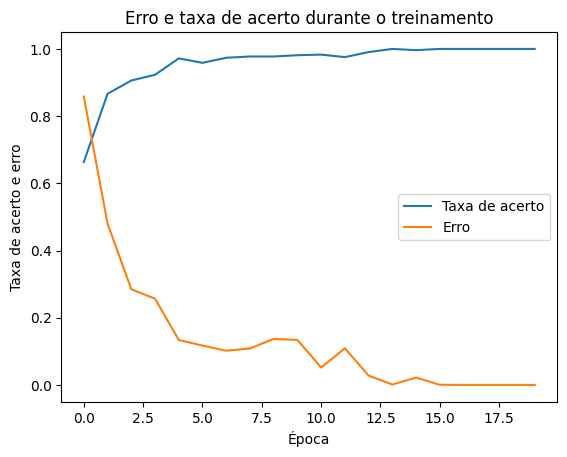

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [31]:
test_directory = 'data\Test'

In [32]:
os.listdir(test_directory)

['0', '1', '2', '3']

In [33]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [34]:
evaluate = model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8250 - loss: 1.8770


In [35]:
evaluate

[1.8770338296890259, 0.824999988079071]

In [36]:
len(os.listdir(test_directory))

4

In [37]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

In [38]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3]


In [39]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [41]:
accuracy_score(original, prediction)

0.825

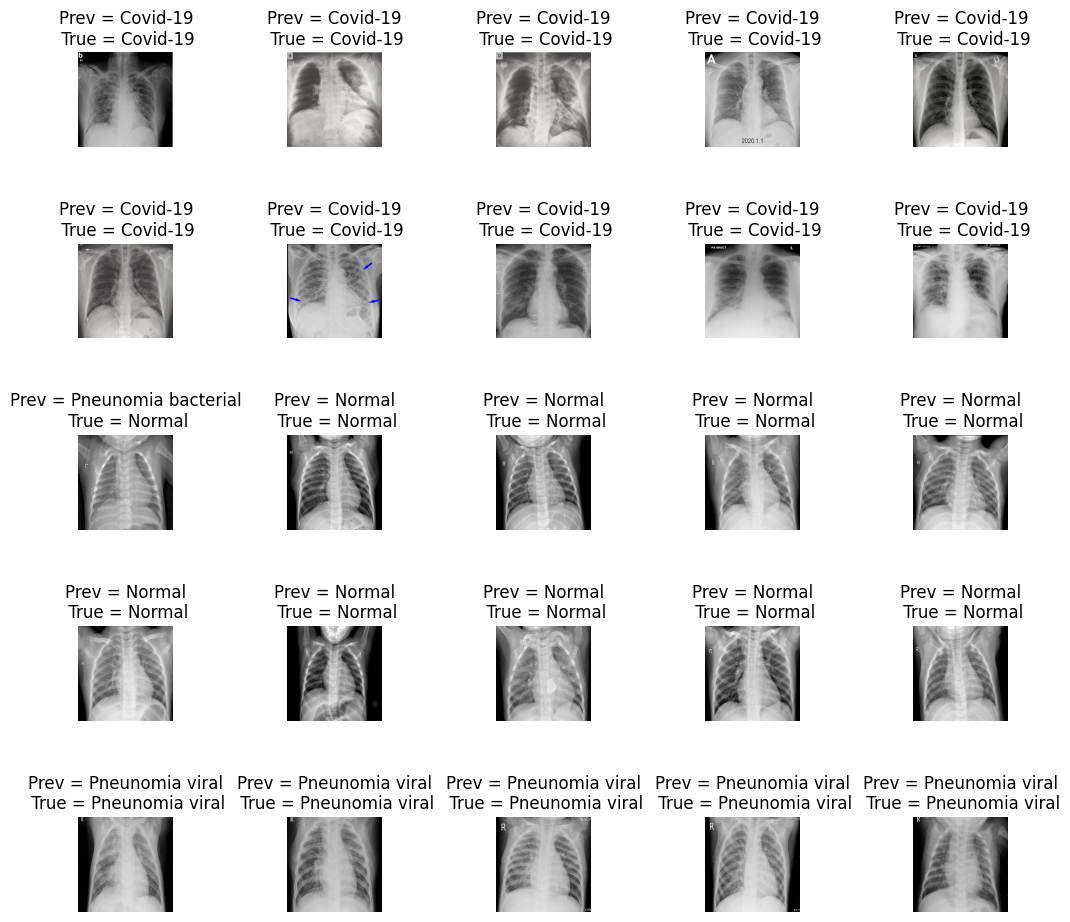

In [42]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title(f'Prev = {labels_names[prediction[i]]}\n True = {labels_names[original[i]]}')
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [43]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

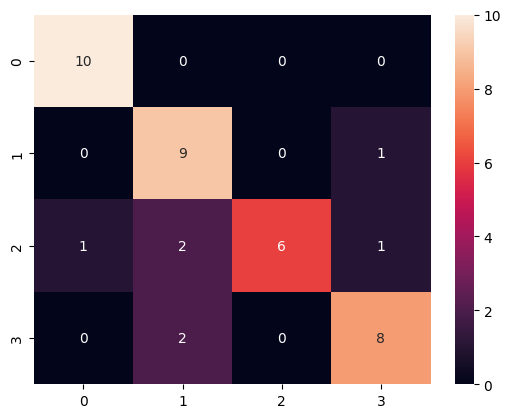

In [44]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [45]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.69      0.90      0.78        10
           2       1.00      0.60      0.75        10
           3       0.80      0.80      0.80        10

    accuracy                           0.82        40
   macro avg       0.85      0.82      0.82        40
weighted avg       0.85      0.82      0.82        40



## Classificação de somente uma imagem

In [46]:
from keras.models import load_model
model_loaded = load_model('weights.keras')

In [47]:
model_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 51,713,930 (197.27 MB)

 Trainable params: 25,830,404 (98.54 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 25,830,406 (98.54 MB)

In [48]:
4 * 4 * 2048

32768

In [58]:
img = cv2.imread('data/Test/3/person1_bacteria_1.jpeg')

In [60]:
# from google.colab.patches import cv2_imshow
#cv2_imshow(img)
#cv2.imshow('image', img)

In [62]:
img = cv2.resize(img, (256, 256))
#cv2_imshow(img)

In [63]:
img = img / 255
img

array([[[0.27058824, 0.27058824, 0.27058824],
        [0.27058824, 0.27058824, 0.27058824],
        [0.25882353, 0.25882353, 0.25882353],
        ...,
        [0.47058824, 0.47058824, 0.47058824],
        [0.4745098 , 0.4745098 , 0.4745098 ],
        [0.4627451 , 0.4627451 , 0.4627451 ]],

       [[0.26666667, 0.26666667, 0.26666667],
        [0.27058824, 0.27058824, 0.27058824],
        [0.25882353, 0.25882353, 0.25882353],
        ...,
        [0.47058824, 0.47058824, 0.47058824],
        [0.47058824, 0.47058824, 0.47058824],
        [0.4627451 , 0.4627451 , 0.4627451 ]],

       [[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27058824, 0.27058824, 0.27058824],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        ...,
        [0.47843137, 0.47843137, 0.47843137],
        [0.47843137, 0.47843137, 0.47843137],
        [0.47058824, 0.47058824, 0.47058824]],

       ...,

       [[0.02745098, 0.02745098, 0.02745098],
        [0.00784314, 0.00784314, 0.00784314],
        [0.1254902 , 0

In [64]:
img.shape

(256, 256, 3)

In [65]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [66]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.01472834, 0.0288167 , 0.00386399, 0.95259094]], dtype=float32)>

In [67]:
predict2 = np.argmax(predict)
predict2

3

In [68]:
labels_names[predict2], predict[0][predict2]

('Pneunomia bacterial', <tf.Tensor: shape=(), dtype=float32, numpy=0.95259094>)